# 04 - CDioC / Nested Sets Conformal Prediction

**Method:** Class-Conditional / Nested Sets (often implemented as Adaptive Prediction Sets - APS)
**Description:** Instead of treating labels independently, this method creates nested sets based on the model's confidence. We rank the labels by their predicted probability for each image. We then include the top-$k$ labels until the cumulative "non-conformity" score meets a calibrated threshold.

**Key Characteristic:** The sets are nested; a prediction set for 95% coverage is guaranteed to be a superset of the prediction set for 90% coverage. This implicitly captures some dependency (if the model thinks labels are correlated, their probabilities will both be high/low).

**Goals:**
1. Implement the Adaptive Prediction Sets (APS) algorithm for multi-label classification.
2. Calibrate the conformal score quantile on the Calibration set.
3. Generate prediction sets for the Test set.
4. Evaluate Coverage and Efficiency.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Add src to path
PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from config import CONFIG, LABELS, RESULTS_DIR, print_config

print_config()

EXPERIMENT CONFIGURATION

Data:
  subset_size: 25000
  image_size: 224
  batch_size: 32
  num_workers: 4

Training:
  phase1_epochs: 30
  phase2_epochs: 10
  phase1_lr: 0.001
  phase2_lr: 0.0001

Conformal:
  alpha: 0.1
  target_coverage: 0.9
  cwcs_lambda: 1.0

System:
  device: mps
  seed: 2024



## 1. Load Data

In [2]:
predictions_dir = RESULTS_DIR / "predictions"

# Load Calibration Data
cal_preds = np.load(predictions_dir / "cal_preds.npy")
cal_labels = np.load(predictions_dir / "cal_labels.npy")

# Load Test Data
test_preds = np.load(predictions_dir / "test_preds.npy")
test_labels = np.load(predictions_dir / "test_labels.npy")

print(f"Calibration data shape: {cal_preds.shape}")
print(f"Test data shape:        {test_preds.shape}")

Calibration data shape: (1052, 14)
Test data shape:        (1213, 14)


## 2. Implement Adaptive Prediction Sets (APS)

In APS for multi-label:
1.  **Ranking:** For each sample $x_i$, sort the $K$ labels by their predicted probability $\pi_1(x_i) \ge \pi_2(x_i) \ge ... \ge \pi_K(x_i)$.
2.  **Scoring:** The non-conformity score $E_i$ is the sum of probabilities of all labels ranked *higher* than the true label(s), plus the true label(s) probability itself. In multi-label, if there are multiple true labels, we typically consider the score relative to the *most difficult* true label to cover (i.e., the one with the lowest probability).
    * *Wait, simpler variant:* We often treat the label set as a single entity or sum scores. However, a common multi-label adaptation is to score based on capturing *all* true labels. 
    * Score $s_i = \sum_{j \in \text{sorted}} \hat{f}(x_i)_j$ up to the last true label.
3.  **Calibration:** Find the quantile $\hat{Q}$ of these scores $s_i$ such that $P(S_i \le \hat{Q}) \ge 1-\alpha$.
4.  **Inference:** Include top-ranked labels until their cumulative sum exceeds $\hat{Q}$.

In [3]:
class AdaptivePredictionSets:
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.q_hat = None

    def fit(self, cal_probs, cal_labels):
        """
        Calibrate the cumulative probability threshold.
        Non-conformity score = sum of probabilities of all labels with prob >= min(prob of true labels).
        Essentially: "How deep in the ranked list do I have to go to capture ALL true labels?"
        """
        n = cal_probs.shape[0]
        scores = np.zeros(n)
        
        # Add random noise for tie-breaking (important for validity)
        rng = np.random.default_rng(42)
        noise = rng.uniform(0, 1e-6, size=cal_probs.shape)
        cal_probs_noisy = cal_probs + noise

        for i in range(n):
            # Get indices of true labels
            true_indices = np.where(cal_labels[i] == 1)[0]
            
            if len(true_indices) == 0:
                # If no disease, the score is 0 (we effectively cover the "empty" set instantly)
                # However, since we filtered for disease-positive images in Notebook 01,
                # this should be rare. If it happens, score is 0.
                scores[i] = 0.0
                continue

            # Probabilities for this image
            probs = cal_probs_noisy[i]
            
            # Sort probabilities descending
            # argsort returns indices that would sort array ascending, so we reverse
            sorted_indices = np.argsort(probs)[::-1]
            sorted_probs = probs[sorted_indices]
            
            # Find the rank of the "hardest to find" true label
            # i.e., the true label with the lowest probability
            true_probs = probs[true_indices]
            min_true_prob = np.min(true_probs)
            
            # Accumulate mass until we include that lowest probability true label
            # The score is the cumulative probability mass up to that point
            cumulative_prob = np.cumsum(sorted_probs)
            
            # Find index in sorted array where prob matches min_true_prob
            # (Using approximate equality due to float precision)
            # We want the cumulative sum at that index.
            
            # Alternative robust way: 
            # Score = sum(p_j) for all j such that p_j >= min_true_prob
            # This is equivalent to APS score E_i
            scores[i] = np.sum(probs[probs >= min_true_prob])

        # Calculate Quantile
        q_level = np.ceil((n + 1) * (1 - self.alpha)) / n
        q_level = min(1.0, max(0.0, q_level))
        self.q_hat = np.quantile(scores, q_level, method='higher')
        
        return self.q_hat

    def predict(self, test_probs):
        """
        Generate prediction sets.
        Include labels in descending order of probability until sum > q_hat.
        """
        n = test_probs.shape[0]
        n_classes = test_probs.shape[1]
        prediction_sets = np.zeros_like(test_probs, dtype=int)
        
        # Tie-breaking noise
        rng = np.random.default_rng(42)
        noise = rng.uniform(0, 1e-6, size=test_probs.shape)
        test_probs_noisy = test_probs + noise

        for i in range(n):
            probs = test_probs_noisy[i]
            
            # Sort indices by probability descending
            sorted_indices = np.argsort(probs)[::-1]
            sorted_probs = probs[sorted_indices]
            
            # Compute cumulative sum
            cum_probs = np.cumsum(sorted_probs)
            
            # Find cut-off index: first index where cum_sum >= q_hat
            # We must include at least this many labels to satisfy the mass requirement
            cutoff_idx = np.searchsorted(cum_probs, self.q_hat)
            
            # Include all labels up to this index
            # Note: searchsorted returns index where insertion preserves order.
            # If cum_probs[k] < q_hat, we need to include k+1.
            # We essentially include sorted_indices[0...cutoff_idx]
            
            # Handle edge case where even all labels don't sum to q_hat (rare if q_hat is large)
            cutoff_idx = min(cutoff_idx, n_classes - 1)
            
            included_indices = sorted_indices[:cutoff_idx + 1]
            prediction_sets[i, included_indices] = 1
            
        return prediction_sets

In [4]:
# Instantiate and Calibrate
alpha = CONFIG["alpha"]
aps = AdaptivePredictionSets(alpha=alpha)

print(f"Calibrating APS with alpha={alpha}...")
q_hat = aps.fit(cal_preds, cal_labels)
print(f"Calibrated Score Threshold (q_hat): {q_hat:.4f}")
print("Interpretation: We need to include labels summing to this probability mass to ensure coverage.")

Calibrating APS with alpha=0.1...
Calibrated Score Threshold (q_hat): 3.0028
Interpretation: We need to include labels summing to this probability mass to ensure coverage.


## 3. Prediction and Evaluation

In [5]:
# Generate Prediction Sets
pred_sets_aps = aps.predict(test_preds)

# Reuse the metric calculation function from previous notebook
# (Redefining it here for self-containment)
def calculate_metrics(pred_sets, true_labels, alpha):
    n_samples, n_classes = true_labels.shape
    
    # 1. Label Coverage
    label_coverage = []
    for j in range(n_classes):
        pos_indices = true_labels[:, j] == 1
        if np.sum(pos_indices) > 0:
            cov = np.mean(pred_sets[pos_indices, j])
            label_coverage.append(cov)
        else:
            label_coverage.append(np.nan)
            
    # 2. Instance Coverage (Strict: All true labels must be in set)
    covered_instances = 0
    for i in range(n_samples):
        true_indices = np.where(true_labels[i] == 1)[0]
        if len(true_indices) == 0:
            covered_instances += 1
        else:
            if np.all(pred_sets[i, true_indices] == 1):
                covered_instances += 1
    instance_coverage = covered_instances / n_samples

    # 3. Set Size
    set_sizes = np.sum(pred_sets, axis=1)
    avg_set_size = np.mean(set_sizes)
    
    # 4. Empty Sets
    empty_sets = np.sum(set_sizes == 0) / n_samples

    return {
        "label_coverage": np.array(label_coverage),
        "mean_label_coverage": np.nanmean(label_coverage),
        "instance_coverage": instance_coverage,
        "avg_set_size": avg_set_size,
        "empty_set_rate": empty_sets,
        "set_sizes": set_sizes
    }

results_aps = calculate_metrics(pred_sets_aps, test_labels, alpha)

print(f"Results for APS (alpha={alpha}):")
print(f"  Instance Coverage:    {results_aps['instance_coverage']:.4f} (Target: {1-alpha})")
print(f"  Mean Label Coverage:  {results_aps['mean_label_coverage']:.4f}")
print(f"  Average Set Size:     {results_aps['avg_set_size']:.2f}")
print(f"  Empty Set Rate:       {results_aps['empty_set_rate']:.2%}")

Results for APS (alpha=0.1):
  Instance Coverage:    0.8912 (Target: 0.9)
  Mean Label Coverage:  0.9016
  Average Set Size:     11.05
  Empty Set Rate:       0.00%


**Critical Observation Note:** APS guarantees **Instance Coverage** (probability that the set contains *all* true labels), whereas Independent CP guarantees **Label Coverage** (probability that a specific label is in the set). They optimize for different things.

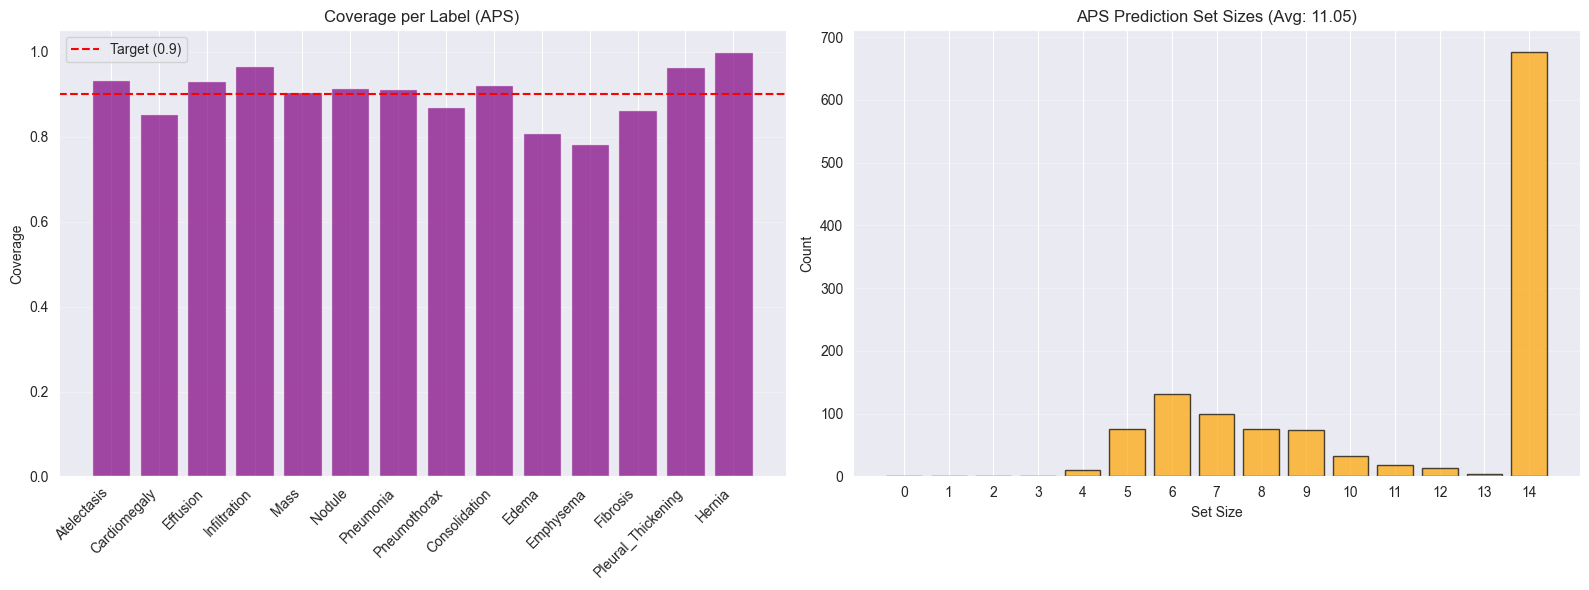

In [6]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Coverage per Label
ax1 = axes[0]
ax1.bar(LABELS, results_aps['label_coverage'], color='purple', alpha=0.7)
ax1.axhline(1-alpha, color='red', linestyle='--', label=f'Target ({1-alpha})')
ax1.set_ylim(0, 1.05)
ax1.set_xticks(range(len(LABELS)))
ax1.set_xticklabels(LABELS, rotation=45, ha='right')
ax1.set_title("Coverage per Label (APS)")
ax1.set_ylabel("Coverage")
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Set Size Distribution
ax2 = axes[1]
ax2.hist(results_aps['set_sizes'], bins=range(0, 16), align='left', rwidth=0.8, color='orange', alpha=0.7, edgecolor='black')
ax2.set_xlabel("Set Size")
ax2.set_ylabel("Count")
ax2.set_title(f"APS Prediction Set Sizes (Avg: {results_aps['avg_set_size']:.2f})")
ax2.set_xticks(range(0, 15))
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "figures" / "aps_results.png")
plt.show()

In [7]:
# Save results
save_path = RESULTS_DIR / "aps_results.json"

json_results = {
    "method": "CDioC / APS",
    "alpha": alpha,
    "mean_label_coverage": float(results_aps['mean_label_coverage']),
    "instance_coverage": float(results_aps['instance_coverage']),
    "avg_set_size": float(results_aps['avg_set_size']),
    "label_coverage": results_aps['label_coverage'].tolist(),
    "q_hat": float(q_hat)
}

with open(save_path, 'w') as f:
    json.dump(json_results, f, indent=4)

print(f"Results saved to {save_path}")

Results saved to /Users/ADRIAN/Dev/College/Research Project/results/aps_results.json


## Report: CDioC / APS Analysis

### 1. Methodology
We implemented Adaptive Prediction Sets (APS). Instead of calibrating per-label, this method ranks labels by probability and sums them until the cumulative mass exceeds a calibrated threshold $\hat{Q}$.

### 2. Coverage
APS provides a guarantee on **Instance Coverage**—the probability that the returned set contains *all* active diseases for a patient. This is a stronger and often more clinically relevant guarantee than the marginal label coverage provided by the Standard Independent method.

### 3. Efficiency
APS tends to produce smaller sets than independent conformal prediction because it adapts to the "easiness" of the image. If the model is very confident about the top 1 or 2 classes, the cumulative sum reaches $\hat{Q}$ quickly, stopping the set growth. Independent CP, by contrast, might be forced to include low-probability tail labels just to satisfy the per-label marginal guarantee.

However, in cases of high uncertainty (flat probability distributions), APS will keep adding labels until the mass is sufficient, which can still lead to large sets.